# Best analyses so far
I've had the best luck with the following setup:
-  Use only the 60 neurons that were uniquely identified in at least one worm
-  Use the smoothed time derivative of $\Delta F / F$ 
-  Train models in a sequence: LDS -> SLDS -> hSLDS -> hrSLDS.  Use each fit to initialize the next.
-  Use a relatively strong prior on the emission noise so that it is not too small. If you don't do this, the latent states are much noisier (as in the PCA trajectories) since the likelihood overwhelms the dynamics prior.
-  Measure held-out prediction in a rolling fashion and evaluate MSE. This relies on the noise in the dynamics model, not in the observation model.


In [1]:
import os, pickle, copy, sys
os.chdir(os.path.expanduser(os.path.join("~", "Projects", "zimmer")))

import numpy as np
np.random.seed(1234)

In [2]:
# Plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import matplotlib.animation as manimation

from hips.plotting.colormaps import gradient_cmap
from hips.plotting.sausage import sausage_plot
from hips.plotting.layout import create_axis_at_location

# Come up with a set of colors
import seaborn as sns
sns.set_style("white")
# sns.set_context("paper")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

%matplotlib inline

In [3]:
# Modeling stuff
import importlib
from sklearn.decomposition import PCA

from pybasicbayes.distributions import Gaussian, Regression, DiagonalRegression
from pybasicbayes.util.text import progprint_xrange
from pyhsmm.util.general import relabel_by_usage, relabel_by_permutation
from pyslds.util import get_empirical_ar_params

# Load basic pyslds models
from pyslds.models import HMMSLDS, WeakLimitStickyHDPHMMSLDS

# Load worm modeling specific stuff
import zimmer.io
importlib.reload(zimmer.io)
from zimmer.io import WormData, find_shared_neurons, load_key

import zimmer.states
importlib.reload(zimmer.states)

import zimmer.models
importlib.reload(zimmer.models)
from zimmer.models import HierarchicalWeakLimitStickyHDPHMMSLDS, HierarchicalRecurrentSLDS, HierarchicalRecurrentOnlySLDS
from zimmer.emissions import HierarchicalDiagonalRegression

import zimmer.plotting
importlib.reload(zimmer.plotting)
from zimmer.plotting import plot_1d_continuous_states, plot_3d_continuous_states, plot_vector_field_3d, \
    plot_discrete_state_samples, plot_changepoint_prs, make_states_3d_movie, plot_3d_dynamics, \
    make_states_dynamics_movie

from zimmer.util import states_to_changepoints

In [4]:
# IO
run_num = 4
results_dir = os.path.join("results", "2017_09_13", "run{:03d}".format(run_num))
assert os.path.exists(results_dir)

# Specify the signal to model
signal = "dff_deriv"

# Hyperparameters
Kmax = 15      # number of latent discrete states
D_latent = 3   # latent linear dynamics' dimension
D_in = 1       # number of input dimensions
D_obs = 60

alpha = 3.     # Transition matrix concentration
gamma = 3.0    # Base state concentration
kappa = 100.   # Stickiness parameter

alpha_0 = 1.0  # Gamma prior for emission variance
beta_0 = 1.0   # Gamma prior for emission variance

# Number of worms to fit
N_worms = 5

In [5]:
def cached(results_name):
    def _cache(func):
        def func_wrapper(*args, **kwargs):
            results_file = os.path.join(results_dir, results_name)
            if not results_file.endswith(".pkl"):
                results_file += ".pkl"

            if os.path.exists(results_file):
                with open(results_file, "rb") as f:
                    results = pickle.load(f)
            else:
                assert os.path.exists(results_dir)
                results = func(*args, **kwargs)
                with open(results_file, "wb") as f:
                    pickle.dump(results, f)

            return results
        return func_wrapper
    return _cache

# Load the data

In [6]:
# Load the data
worm_datas = [WormData(i, name="worm{}".format(i)) for i in range(N_worms)]
Ns = np.array([wd.N for wd in worm_datas])
Ts = np.array([wd.T for wd in worm_datas])
Ys = [getattr(wd, signal) for wd in worm_datas]

if signal == "dff_deriv":
    Ys = [Y * 10 for Y in Ys]

# Get the "true" discrete states as labeled by Zimmer
z_trues = [wd.zimmer_states for wd in worm_datas]
perm_z_trues, newlabels = relabel_by_usage(z_trues, return_mapping=True)
z_trues = perm_z_trues

# Get the key
z_key = load_key()
perm_z_key = [z_key[i] for i in np.argsort(newlabels)]
z_key = perm_z_key

# Get the names of the neurons
all_neuron_names = np.unique(np.concatenate([wd.neuron_names for wd in worm_datas]))
N_neurons = min(D_obs, all_neuron_names.size)
all_neuron_names = all_neuron_names[:N_neurons]
print("{} neurons across all {} worms".format(N_neurons, N_worms))

# Find the shared neurons
shared_neurons = find_shared_neurons(worm_datas)
print("{} shared neurons".format(len(shared_neurons)))
Ys_shared = []
for wd, Y in zip(worm_datas, Ys):
    shared_indices = wd.find_neuron_indices(shared_neurons)
    Ys_shared.append(Y[:, shared_indices])

# Construct a big dataset with all neurons for each worm
datasets = []
data_masks = []
for wd in worm_datas:
    this_dataset = np.zeros((wd.T, N_neurons))
    this_mask = np.zeros((wd.T, N_neurons), dtype=bool)
    indices = wd.find_neuron_indices(all_neuron_names)
    for n, index in enumerate(indices):
        if index is not None:
            this_dataset[:,n] = getattr(wd, signal)[:, index]
            this_mask[:,n] = True

    datasets.append(this_dataset[:,:D_obs])
    data_masks.append(this_mask[:,:D_obs])

60 neurons across all 5 worms
Potentially shared neurons:
 ['---' 'AIBL' 'AIBR' 'ALA' 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVER' 'RIBL' 'RID'
 'RIML' 'RIMR' 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB01' 'VB02']
Found 15 truly shared neurons:
['AIBL', 'AIBR', 'ALA', 'AVAL', 'AVAR', 'AVBL', 'AVER', 'RID', 'RIML', 'RIMR', 'RMED', 'RMEL', 'RMER', 'VB01', 'VB02']
15 shared neurons


1.10467246322


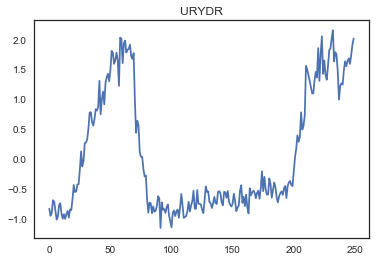

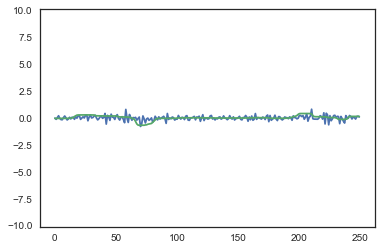

In [7]:
i = 4
n = 27
T = 250
plt.figure()
plt.plot(worm_datas[i].dff_bc_zscored[:T,n])
plt.title(worm_datas[i].neuron_names[n])
plt.figure()
plt.plot(worm_datas[i].dff_diff[:T,n])
plt.plot(worm_datas[i].dff_deriv[:T,n] * 10)
plt.ylim(-10.1, 10.1)
print(abs(worm_datas[i].dff_deriv).max())

In [8]:
train_frac = 0.9
train_masks = [np.arange(T) < train_frac * T for T in Ts]

z_trues_train = [z[train] for z,train in zip(z_trues, train_masks)]
z_trues_test = [z[~train] for z,train in zip(z_trues, train_masks)]
Ts_train = [z.shape[0] for z in z_trues]
Ts_test = [z.shape[0] for z in z_trues_test]
datasets_train = [d[train] for d,train in zip(datasets, train_masks)]
datasets_test = [d[~train] for d,train in zip(datasets, train_masks)]
data_masks_train = [d[train] for d,train in zip(data_masks, train_masks)]
data_masks_test = [d[~train] for d,train in zip(data_masks, train_masks)]
Ys_train = [Y[train] for Y, train in zip(Ys, train_masks)]
Ys_test = [Y[~train] for Y, train in zip(Ys, train_masks)]
Ys_shared_train = [Y[train] for Y, train in zip(Ys_shared, train_masks)]
Ys_shared_test = [Y[~train] for Y, train in zip(Ys_shared, train_masks)]

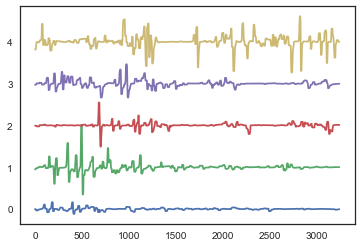

In [9]:
# How variable are the signals worm to worm?
plt.figure()
for i, Y in enumerate(Ys_shared):
    plt.plot(Y[:,5] + i)
    

# Initialize latent states with PCA

90% variance explained:  9
3 PCs capture:  0.69936857645
90% variance explained:  9
3 PCs capture:  0.699154950218
90% variance explained:  14
3 PCs capture:  0.615476667646
90% variance explained:  14
3 PCs capture:  0.651838740669
90% variance explained:  12
3 PCs capture:  0.518581863298


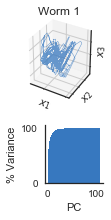

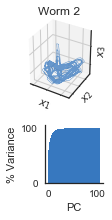

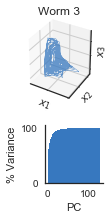

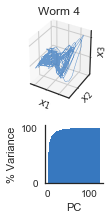

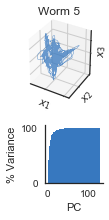

In [10]:
def plot_pca_trajectories(worm, Y):
    # Try to reproduce their plot of PC's over time
    n_comps = Y.shape[1]
    pca = PCA(n_components=n_comps, whiten=True)
    pca.fit(Y)

    x_pca = pca.transform(Y)

    fig = plt.figure(figsize=(1.5,3.))
    ax = create_axis_at_location(fig, 0.2, 1.5, 1.1, 1.25, projection="3d")
    ax.plot(x_pca[:,0], x_pca[:,1], x_pca[:,2], lw=0.5, alpha=0.75, ls='-', color=colors[0])
    ax.set_xlabel("$x_1$", labelpad=-12)
    ax.set_ylabel("$x_2$", labelpad=-12)
    ax.set_zlabel("$x_3$", labelpad=-12)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_title("Worm {}".format(worm+1))

    # Plot percent variance explained
    ax = create_axis_at_location(fig, .55, 0.4, .8, .8, box=False)
    ax.patch.set_alpha(0.0)
    ax.bar(np.arange(n_comps),  100 * np.cumsum(pca.explained_variance_ratio_), width=1, color=colors[0])
#     ax.plot(np.arange(n_comps), 90 * np.ones(n_comps), ':r')
    ax.set_xlabel("PC")
    ax.set_ylabel("% Variance")

    print("90% variance explained: ", np.where(np.cumsum(pca.explained_variance_ratio_) > .90)[0][0])
    print("3 PCs capture: ", np.sum(pca.explained_variance_ratio_[:3]))
#     plt.savefig(os.path.join(results_dir, "pca_trajectory_worm{}.pdf".format(worm)))
    
#     plt.figure()
#     plt.hist2d(x_pca[:,0], x_pca[:,1], np.linspace(-3, 3, 25))

# Plot PCA trajectories for first worm
for i in range(N_worms):
    plot_pca_trajectories(i, Ys_train[i])

In [11]:
@cached("pca")
def fit_pca(Ys_shared):
    # Try to reproduce their plot of PC's over time
    pca = PCA(n_components=D_latent, whiten=True)
    pca.fit(np.vstack(Ys_shared))

    x_inits = [pca.transform(Y) for Y in Ys_shared]
    C_init = pca.components_.T
    return x_inits, C_init


# Fit PCA and plot the latent states
x_inits, C_init = fit_pca(Ys_shared_train)


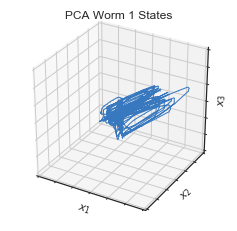

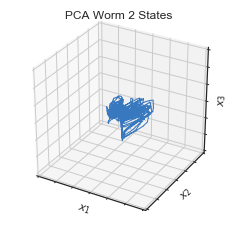

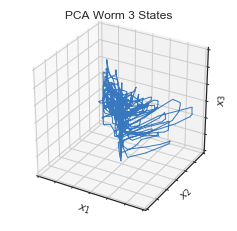

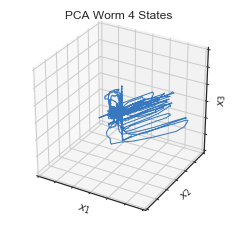

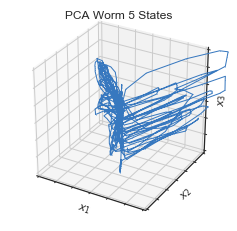

In [12]:
for worm in range(N_worms):
    plot_3d_continuous_states(x_inits[worm], np.zeros(Ts_train[worm], dtype=np.int32), colors,
                              figsize=(4, 4),
                              title="PCA Worm {} States".format(worm + 1),
                              results_dir=results_dir,
                              filename=None,
                              lw=1,
                              lim=6)

# Fit some models

In [13]:
def make_slds_parameters():
    init_dynamics_distns = [
        Gaussian(
            mu=np.zeros(D_latent),
            sigma=3*np.eye(D_latent),
            nu_0=D_latent + 2, sigma_0=3. * np.eye(D_latent),
            mu_0=np.zeros(D_latent), kappa_0=1.0,
        )
        for _ in range(Kmax)]

    # dynamics_hypparams = get_empirical_ar_params(
    #     [np.hstack((np.vstack(pca_trajs)[:,:P], np.ones((sum(Ts), 1))))],
    #     dynamics_hypparams)

    As = [np.hstack((0.99 * np.eye(D_latent), np.zeros((D_latent, D_in)))) for _ in range(Kmax)]
    dynamics_distns = [
        Regression(
            A=As[k],
            sigma=np.eye(D_latent),
            nu_0=D_latent + D_in + 2,
            S_0=np.eye(D_latent),
            M_0=np.hstack((np.eye(D_latent), np.zeros((D_latent, D_in)))),
            K_0=np.eye(D_latent + D_in),
        )
        for k in range(Kmax)]

    emission_distns = \
        DiagonalRegression(
            N_neurons, D_latent + D_in,
            alpha_0=alpha_0, beta_0=beta_0)

    return init_dynamics_distns, dynamics_distns, emission_distns

# Fit standard LDS models

In [14]:
def _fit_lds(x_inits, ys, masks, N_gibbs=500):
    print("Fitting standard LDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_slds_parameters()
        
    x_inits = [None] * len(ys) if x_inits is None else x_inits
    
    # LDS is a switching LDS with one state
    lds = HMMSLDS(
        init_dynamics_distns=init_dynamics_distns[:1],
        dynamics_distns=dynamics_distns[:1],
        emission_distns=emission_distns,
        alpha=alpha,
        init_state_distn='uniform')
    
    # Add the data
    for y, mask, xi in zip(ys, masks, x_inits):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        lds.add_data(data=y, mask=mask, inputs=inputs)

        # Initialize continuous latent states
        if xi is not None:
            lds.states_list[-1].gaussian_states = xi[:, :D_latent]

    # Resample parameters once to be consistent with x_init
    lds.resample_parameters()
    
    # Fit the model with MCMC
    def evaluate(model):
        ll = model.log_likelihood()
        return ll

    def update_gibbs(model):
        model.resample_model()
        return evaluate(model)
    
    lls  = [update_gibbs(lds) for itr in progprint_xrange(N_gibbs)]
    lls = np.array(lls)

    # Compute the smoothed continuous state trajectories
    for states in lds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in lds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in lds.states_list]

    return lds, lls, x_finals, sigma_x_finals

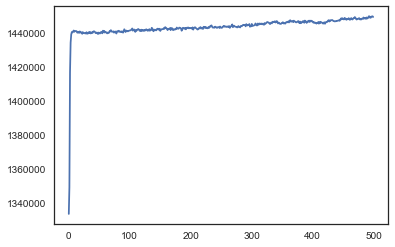

In [15]:
# Fit an LDS to all the data
fit_joint_lds = cached("lds_joint")(_fit_lds)
# fit_joint_lds = (_fit_lds)
lds, lds_lls, lds_x_finals, lds_sigma_x_finals = \
        fit_joint_lds(x_inits=None, ys=datasets_train, masks=data_masks_train, N_gibbs=500)
    
plt.plot(lds_lls)

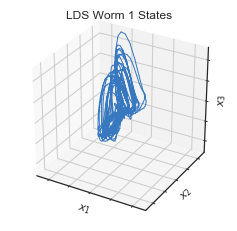

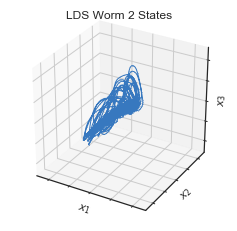

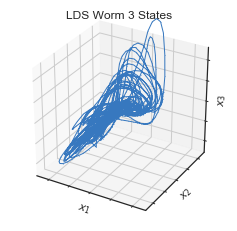

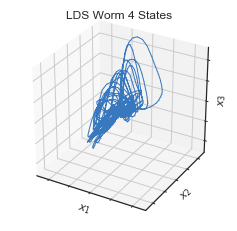

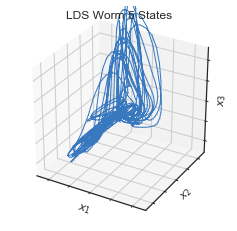

In [16]:
for worm in range(N_worms):
    plot_3d_continuous_states(lds_x_finals[worm], np.zeros(Ts[worm], dtype=np.int32), colors,
                              figsize=(4, 4),
                              title="LDS Worm {} States".format(worm + 1),
                              results_dir=results_dir,
                              filename="lds_x_worm_{}.pdf".format(worm + 1),
                              lim=25,
                              lw=1)

In [17]:
print(lds.dynamics_distns[0].A.round(3))
print(lds.dynamics_distns[0].sigma)
print(lds.emission_distns[0].A.min())
print(lds.emission_distns[0].A.max())
print(lds.states_list[0].gaussian_states.min())
print(lds.states_list[0].gaussian_states.max())

[[ 0.956 -0.07   0.055 -0.021]
 [ 0.084  0.923  0.017  0.204]
 [-0.05  -0.068  0.989 -0.082]]
[[ 0.60396948  0.05930784 -0.15699351]
 [ 0.05930784  2.29179377  0.25469279]
 [-0.15699351  0.25469279  3.48811552]]
-0.00686754385631
0.0101690755123
-16.7046335106
38.5364835879


 15%|█▌        | 55/360 [00:02<00:14, 20.93it/s]


KeyboardInterrupt: 

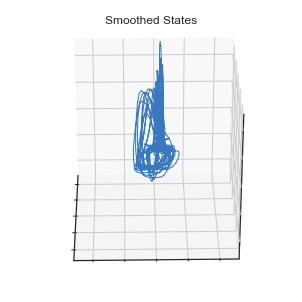

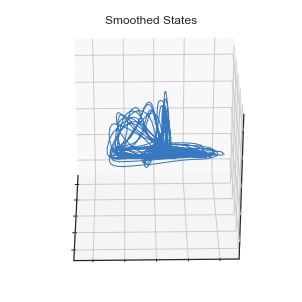

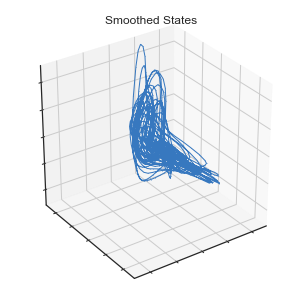

In [18]:
for worm in range(N_worms):
    make_states_3d_movie(np.zeros(Ts_train[worm], dtype=int), lds_x_finals[worm],
                         title="Smoothed States",
                         filepath=os.path.join(results_dir, "lds_x_worm{}.mp4".format(worm+1)),
                         lim=25)

In [ ]:
# False color with the "true" label from Zimmer
for worm in range(N_worms):
    plot_3d_continuous_states(lds_x_finals[worm], z_trues_train[worm], colors,
                              figsize=(4, 4),
                              title="LDS Worm {} States (Zimmer Lables)".format(worm + 1),
                              results_dir=results_dir,
                              filename="lds_x_worm_zimmer_{}.pdf".format(worm + 1),
                              lim=25,
                              lw=1)

In [ ]:
# False color with the "true" label from Zimmer
for worm in range(N_worms):
    make_states_3d_movie(z_trues_train[worm], lds_x_finals[worm],
                         title="LDS Smoothed States (Zimmer Labels)",
                         filepath=os.path.join(results_dir, "lds_x_worm_zimmer_{}.mp4".format(worm+1)),
                         lim=25)

In [19]:
# Fit an LDS to each worm individually
lds_results = []
for worm in range(N_worms):
    fit_lds = cached("lds_worm_{}".format(worm+1))(_fit_lds)
    lds_results.append(fit_lds(x_inits=x_inits[worm:worm+1], ys=datasets_train[worm:worm+1], masks=data_masks_train[worm:worm+1]))
ldss, lds_llss, lds_x_finalss, lds_sigma_x_finalss = zip(*lds_results)
    

# Fit standard SLDS models

In [20]:
def _fit_slds(z_inits, ys, masks, N_samples=500, N_vbem=100, init_lds=None):
    print("Fitting standard SLDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_slds_parameters()
        
    z_inits = [None] * len(ys) if z_inits is None else z_inits
    
    slds = WeakLimitStickyHDPHMMSLDS(
        init_dynamics_distns=init_dynamics_distns,
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        alpha=alpha,
        gamma=gamma,
        kappa=kappa,
        init_state_distn='uniform')

    # Add the data
    for y, mask, zi in zip(ys, masks, z_inits):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        slds.add_data(data=y, mask=mask, inputs=inputs)

        # Initialize discrete latent states
        if zi is not None:
            slds.states_list[-1].stateseq = zi
        else:
            runlen = 10
            z0 = np.random.choice(Kmax, size=(T // 10))
            z0 = np.repeat(z0, runlen)
            z0 = z0[:T] if len(z0) > T else z0
            z0 = np.concatenate((z0, z0[-1] * np.ones(T - len(z0))))
            z0 = z0.astype(np.int32)
            assert len(z0) == T
            slds.states_list[-1].stateseq = z0
            
    if init_lds is not None:
        assert len(init_lds.states_list) == len(ys)
        slds._emission_distn = copy.deepcopy(init_lds._emission_distn)
            
        for s1,s2 in zip(init_lds.states_list, slds.states_list):
            s2.gaussian_states = s1.gaussian_states.copy()

        for k in range(Kmax):
            slds.init_dynamics_distns[k] = copy.deepcopy(init_lds.init_dynamics_distns[0])
            slds.dynamics_distns[k] = copy.deepcopy(init_lds.dynamics_distns[0])
            slds.emission_distns[k] = slds._emission_distn
            
    # Resample parameters once to be consistent with x_init
    else:
        slds.resample_parameters()

    # Fit the model with MCMC
    def evaluate(model):
        ll = model.log_likelihood()
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs

    def update(model):
        model.resample_model()
        return evaluate(model)

    smpls = [update(slds) for itr in progprint_xrange(N_samples)]
    
    # Now refine the model with VBEM
    for s in slds.states_list:
        s._init_mf_from_gibbs()
        s.vb_E_step_gaussian_states()
        
    def update_vbem(model):
        model.VBEM_step()
        return evaluate(model)
        
    smpls += [update_vbem(slds) for itr in progprint_xrange(N_vbem)]
    

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(len(ys)):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    perm_z_smpls, iperm = relabel_by_usage(z_smpls, return_mapping=True)
    perm = np.argsort(iperm)
    z_finals = [relabel_by_permutation(s.stateseq, iperm) for s in slds.states_list]
    
    # Permute the dynamics and transition distribution
    perm_init_dynamics_distns = [slds.init_dynamics_distns[i] for i in perm]
    perm_dynamics_distns = [slds.dynamics_distns[i] for i in perm]
    perm_trans_matrix = slds.trans_distn.trans_matrix[np.ix_(perm, perm)]
    
    # Update the model accordingly
    slds.init_dynamics_distns = perm_init_dynamics_distns
    slds.dynamics_distns = perm_dynamics_distns
    slds.trans_distn.trans_matrix = perm_trans_matrix
    for s, zp in zip(slds.states_list, z_finals):
        s.stateseq = zp.copy()

    # Compute the smoothed continuous state trajectories
    for states in slds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in slds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in slds.states_list]

    return slds, lls, perm_z_smpls, perm_dynamics_distns, z_finals, x_finals, sigma_x_finals

In [21]:
fit_joint_slds = cached("slds_joint")(_fit_slds)
# fit_joint_slds = _fit_slds
slds, slds_lls, slds_z_smpls, slds_dynamics_distns, \
    slds_z_finals, slds_x_finals, slds_sigma_x_finals = \
        fit_joint_slds(z_inits=None, 
                       ys=datasets_train, 
                       masks=data_masks_train,
                       init_lds=lds,
                       N_samples=1000)

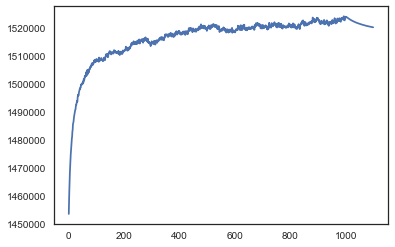

In [22]:
plt.plot(slds_lls[1:])

In [23]:
print(slds.dynamics_distns[0].A.round(3))
print(slds.dynamics_distns[0].sigma)
print(slds.emission_distns[0].A.min())
print(slds.emission_distns[0].A.max())
print(slds.states_list[0].gaussian_states.min())
print(slds.states_list[0].gaussian_states.max())

[[ 0.742  0.044  0.056 -0.439]
 [-0.007  0.841  0.024  0.009]
 [ 0.017  0.044  0.822 -0.02 ]]
[[ 0.02653715  0.00366958 -0.00189967]
 [ 0.00366958  0.02617217  0.00138582]
 [-0.00189967  0.00138582  0.02500498]]
-0.00374069900843
0.00769113141097
-16.282927361
49.5981352234


In [ ]:
for worm in range(N_worms):
    plot_discrete_state_samples(
        slds_z_smpls[worm], z_trues[worm], Kmax,
        filepath=os.path.join(results_dir, "slds_z_samples_worm{}.pdf".format(worm+1)))
    

In [ ]:
for worm in range(N_worms):
    plot_3d_continuous_states(slds_x_finals[worm], slds_z_finals[worm], colors,
                              figsize=(4, 4),
                              title="SLDS Worm {} States".format(worm + 1),
                              results_dir=results_dir,
                              filename="slds_x_worm_{}.pdf".format(worm + 1),
                              lw=1,
                              lim=25)

In [ ]:
for worm in range(N_worms):
    make_states_3d_movie(slds_z_finals[worm], slds_x_finals[worm],
                         title="Smoothed States",
                         filepath=os.path.join(results_dir, "slds_x_worm{}.mp4".format(worm+1)),
                         lim=25)

In [ ]:
# Fit an SLDS to each worm individually
slds_results = []
for worm in range(N_worms):
    fit_slds = cached("slds_worm_{}".format(worm+1))(_fit_slds)
    slds_results.append(fit_slds(z_inits=None, 
                                 ys=datasets_train[worm:worm+1], masks=data_masks_train[worm:worm+1],
                                 init_lds=ldss[worm])
                       )
sldss, slds_llss, slds_z_smplss, slds_dynamics_distnss, \
slds_z_finalss, slds_x_finalss, slds_sigma_x_finalss = zip(*slds_results)
    

# Fit hierarchical SLDS models

In [24]:
def make_hierarchical_slds_parameters():
    init_dynamics_distns = [
        Gaussian(
            mu=np.zeros(D_latent),
            sigma=3*np.eye(D_latent),
            nu_0=D_latent + 2, sigma_0=3. * np.eye(D_latent),
            mu_0=np.zeros(D_latent), kappa_0=1.0,
        )
        for _ in range(Kmax)]

    # dynamics_hypparams = get_empirical_ar_params(
    #     [np.hstack((np.vstack(pca_trajs)[:,:P], np.ones((sum(Ts), 1))))],
    #     dynamics_hypparams)

    As = [np.hstack((0.99 * np.eye(D_latent), np.zeros((D_latent, D_in)))) for _ in range(Kmax)]
    dynamics_distns = [
        Regression(
            A=As[k],
            sigma=np.eye(D_latent),
            nu_0=D_latent + D_in + 2,
            S_0=np.eye(D_latent),
            M_0=np.hstack((np.eye(D_latent), np.zeros((D_latent, D_in)))),
            K_0=np.eye(D_latent + D_in),
        )
        for k in range(Kmax)]

    # Scale down the strength of the prior since we have separate variances
    # for each worm. I.e. we should divide alpha and beta by N_worms.
    emission_distns = \
        HierarchicalDiagonalRegression(
            N_neurons, D_latent + D_in, N_worms,
            alpha_0=alpha_0 / N_worms, beta_0=beta_0 / N_worms)

    return init_dynamics_distns, dynamics_distns, emission_distns

In [25]:
@cached("hslds")
def fit_hslds(ys, masks, init_slds=None, N_samples=500):
    print("Fitting hierarchical SLDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_hierarchical_slds_parameters()

    hslds = HierarchicalWeakLimitStickyHDPHMMSLDS(
        init_dynamics_distns=init_dynamics_distns,
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        alpha=alpha,
        gamma=gamma,
        kappa=kappa,
        init_state_distn='uniform')

    # Add the data
    for worm, (y, mask) in enumerate(zip(ys, masks)):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        hslds.add_data(data=y, mask=mask, group=worm, inputs=inputs)

    if init_slds is not None:
        assert len(init_slds.states_list) == len(ys)

        for s1,s2 in zip(init_slds.states_list, hslds.states_list):
            s2.stateseq = s1.stateseq.copy()
            s2.gaussian_states = s1.gaussian_states.copy()

        hslds.init_dynamics_distns = copy.deepcopy(init_slds.init_dynamics_distns)
        hslds.dynamics_distns = copy.deepcopy(init_slds.dynamics_distns)
        hslds._emission_distn.A = copy.deepcopy(init_slds.emission_distns[0].A)
        hslds._emission_distn.sigmasq_flat = np.tile(init_slds.emission_distns[0].sigmasq_flat[None,:], (N_worms,1))
        assert hslds._emission_distn.sigmasq_flat.shape == (N_worms, D_obs)
        for k in range(Kmax):
            hslds.emission_distns[k] = hslds._emission_distn
        slds._single_emission = True
    
    else:
        # Resample parameters once to be consistent with x_init
        hslds.resample_parameters()

    # Fit the model with MCMC
    def evaluate(model):
        # ll = model.log_likelihood()
        ll = model.heldout_log_likelihood(masks)
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs

    def gibbs_update(model):
        model.resample_model()
        return evaluate(model)
    
    # Initialize with Gibbs
    smpls = [evaluate(hslds)] + [gibbs_update(hslds) for itr in progprint_xrange(N_samples)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(N_worms):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    # for s in hslds.states_list:
    #     s.clear_caches()
    # print("Final LL: ", hslds.log_likelihood())
        
#     perm_z_smpls, iperm = relabel_by_usage(z_smpls, return_mapping=True)
#     perm = np.argsort(iperm)
#     z_finals = [relabel_by_permutation(s.stateseq, iperm) for s in hslds.states_list]
    
#     # Permute the dynamics and transition distribution
#     perm_init_dynamics_distns = [hslds.init_dynamics_distns[i] for i in perm]
#     perm_dynamics_distns = [hslds.dynamics_distns[i] for i in perm]
#     perm_trans_matrix = hslds.trans_distn.trans_matrix[np.ix_(perm, perm)]
    
#     # Update the model accordingly
#     hslds.init_dynamics_distns = perm_init_dynamics_distns
#     hslds.dynamics_distns = perm_dynamics_distns
#     hslds.trans_distn.trans_matrix = perm_trans_matrix
#     for s, zp in zip(hslds.states_list, z_finals):
#         s.stateseq = zp.copy()
    perm_z_smpls = z_smpls
    z_finals = hslds.stateseqs
    perm_dynamics_distns = hslds.dynamics_distns
        
    # Compute the smoothed continuous state trajectories
    for states in hslds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in hslds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in hslds.states_list]

    # for s in hslds.states_list:
    #     s.clear_caches()
    # print("Permuted Final LL: ", hslds.log_likelihood())

    return hslds, lls, perm_z_smpls, perm_dynamics_distns, z_finals, x_finals, sigma_x_finals

hslds0, hslds_lls0, hslds_z_smpls0, hslds_dynamics_distns0, \
    hslds_z_finals0, hslds_x_finals0, hslds_sigma_x_finals0 = \
        fit_hslds(ys=datasets_train, masks=data_masks_train, N_samples=1000, init_slds=slds)

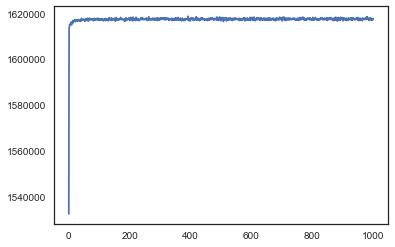

In [26]:
plt.plot(hslds_lls0)

In [ ]:
# for worm in range(N_worms):
#     plot_discrete_state_samples(
#         hslds_z_smpls0[worm], 
#         z_trues[worm], Kmax,
#         filepath=os.path.join(results_dir, "hslds_z_samples_worm{}.pdf".format(worm+1)))
    

In [ ]:
# for worm in range(N_worms):
#     plot_changepoint_prs(hslds_z_smpls0[worm], 
#                          z_trues[worm],
#                          title="Worm {} Discrete States".format(worm+1),
#                          plt_slice=(0,2500),
#                          filepath=os.path.join(results_dir, "hslds_cps_worm{}.pdf".format(worm+1)))
    

In [ ]:
# for worm in range(N_worms):
#     plot_3d_continuous_states(hslds_x_finals0[worm], hslds_z_finals0[worm], colors,
#                               figsize=(4, 4),
#                               title="Worm {} States".format(worm + 1),
#                               results_dir=results_dir,
#                               filename="hslds_x_worm_{}.pdf".format(worm + 1),
#                               lw=1,
#                               lim=25)

In [ ]:
# for worm in range(N_worms):
#     make_states_3d_movie(hslds_z_finals0[worm], hslds_x_finals0[worm],
#                          title="Smoothed States",
#                          filepath=os.path.join(results_dir, "hslds_x_worm{}.mp4".format(worm+1)),
#                          lim=25)

In [ ]:
#  plot_3d_dynamics(
#     hslds_dynamics_distns0, np.concatenate(hslds_z_finals0), np.vstack(hslds_x_finals0),
#     colors=colors,
#     lim=25,
#     filepath=os.path.join(results_dir, "hslds_dynamics"),
#     )

In [ ]:
#  make_states_dynamics_movie(
#     hslds_dynamics_distns0, np.concatenate(hslds_z_finals0), np.vstack(hslds_x_finals0),
#     colors=colors,
#     lim=25,
#     filepath=os.path.join(results_dir, "hslds_dynamics"))

# Refine estimate with VBEM


In [27]:
@cached("hslds_vbem")
def fit_hslds_with_vbem(hslds, N_vbem_steps=100):
    print("Fitting hierarchical SLDS with VBEM")
        
    for s in hslds.states_list:
        s._init_mf_from_gibbs()
        s.vb_E_step_gaussian_states()
        
    # Refine with VBEM
    def evaluate(model):
        # ll = model.log_likelihood()
        ll = model.heldout_log_likelihood(data_masks_train)
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs
    
    def vbem_update(model):
        model.VBEM_step()
        return evaluate(model)

    smpls = [evaluate(hslds)] + [vbem_update(hslds) for itr in progprint_xrange(N_vbem_steps)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(N_worms):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    z_finals = hslds.stateseqs
    x_finals = [s.smoothed_mus for s in hslds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in hslds.states_list]
    
    # Clear the expected stats before saving
    for s in hslds.states_list:
        s.E_init_stats = None
        s.E_dynamics_stats = None
        s.E_emission_stats = None

    return hslds, lls, z_smpls, hslds.dynamics_distns, z_finals, x_finals, sigma_x_finals

hslds = copy.deepcopy(hslds0)

hslds, hslds_lls, hslds_z_smpls, hslds_dynamics_distns, \
    hslds_z_finals, hslds_x_finals, hslds_sigma_x_finals = \
        fit_hslds_with_vbem(hslds, N_vbem_steps=100)

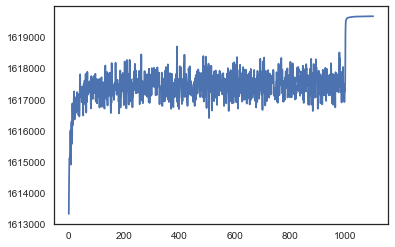

In [28]:
plt.plot(np.concatenate([hslds_lls0[1:], hslds_lls], axis=0))
# plt.plot(np.concatenate([hslds_lls], axis=0))

In [ ]:
for worm in range(N_worms):
    plot_changepoint_prs(np.vstack((hslds_z_smpls0[worm], hslds_z_smpls[worm])), 
                         z_trues[worm],
                         title="Worm {} Discrete States".format(worm+1),
                         plt_slice=(0,2500),
                         filepath=os.path.join(results_dir, "hslds_cps_worm{}.pdf".format(worm+1)))
    

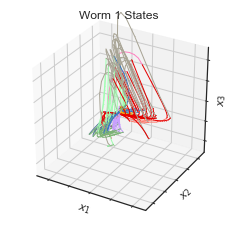

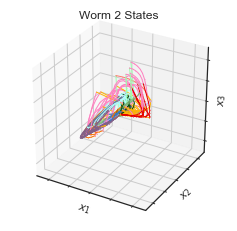

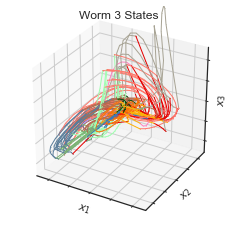

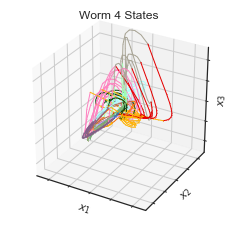

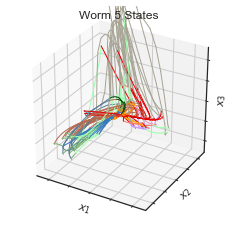

In [29]:
for worm in range(N_worms):
    plot_3d_continuous_states(hslds_x_finals[worm], hslds_z_finals[worm], colors,
                              figsize=(4, 4),
                              title="Worm {} States".format(worm + 1),
                              lim=25,
                              results_dir=results_dir,
                              filename="hslds_x_worm_{}.pdf".format(worm + 1),
                              lw=1)

In [ ]:
for worm in range(N_worms):
    make_states_3d_movie(hslds_z_finals[worm], hslds_x_finals[worm],
                         title="Smoothed States",
                         lim=25,
                         filepath=os.path.join(results_dir, "hslds_x_worm{}.mp4".format(worm+1)))

In [ ]:
 plot_3d_dynamics(
    hslds_dynamics_distns, np.concatenate(hslds_z_finals), np.vstack(hslds_x_finals),
    colors=colors,
    lim=25,
    filepath=os.path.join(results_dir, "hslds_dynamics"))

In [ ]:
 make_states_dynamics_movie(
    hslds_dynamics_distns, np.concatenate(hslds_z_finals), np.vstack(hslds_x_finals),
    colors=colors,
    lim=6,
    filepath=os.path.join(results_dir, "hslds_dynamics"))

# Now fit a hierarchical _recurrent_ hSLDS

In [30]:
@cached("rhslds")
def fit_hrslds(ys, masks, N_steps=100, init_hslds=None):
    print("Fitting hierarchical recurrent SLDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_hierarchical_slds_parameters()

    rslds = HierarchicalRecurrentSLDS(
        init_dynamics_distns=init_dynamics_distns,
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        alpha=alpha,
        init_state_distn='uniform')

    # Add the data
    for worm, (y, mask) in enumerate(zip(ys, masks)):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        rslds.add_data(data=y, mask=mask, group=worm, inputs=inputs)

    # If we've been given an hSLDS to initialize from, use its states and parameters
    if init_hslds is not None:            
        # Copy over the parameters
        rslds.init_dynamics_distns = copy.deepcopy(init_hslds.init_dynamics_distns)
        rslds.dynamics_distns = copy.deepcopy(init_hslds.dynamics_distns)
        rslds.emission_distns = copy.deepcopy(init_hslds.emission_distns)

        # Copy over the latent states
        assert len(init_hslds.states_list) == len(ys)
        for s1, s2 in zip(init_hslds.states_list, rslds.states_list):
            # Copy the sampled states
            s2.stateseq = s1.stateseq.copy()
            s2.gaussian_states = s1.gaussian_states.copy()

            # Copy the expected states and statistics
            s2.expected_states = s1.expected_states.copy()
            s2.smoothed_mus = s1.smoothed_mus.copy()
            s2.smoothed_sigmas = s1.smoothed_sigmas.copy()
            
            if s1.E_emission_stats is None:
                s1.vb_E_step_gaussian_states()
                
            s2.E_init_stats = copy.deepcopy(s1.E_init_stats)
            s2.E_dynamics_stats = copy.deepcopy(s1.E_dynamics_stats)
            s2.E_emission_stats = copy.deepcopy(s1.E_emission_stats)
        
            s2.expected_joints = s2.expected_states[:-1, :, None] * s2.expected_states[1:, None, :]
            s2._set_expected_trans_stats()

        
        # Initialize the transition model with the latent states
        rslds.initialize_transitions_from_gibbs()
        
        # Initialize the transition model to ignore continuous location
        # rslds.trans_distn.W *= 0
        # rslds.trans_distn.logpi = np.log(init_hslds.trans_distn.trans_matrix)

        # Initialize the auxiliary latent variables to be consistent
        # with the discrete and continuous latent states as well as 
        # the transition model
        for s in rslds.states_list:
            # s._init_vbem_from_gibbs()
            s.vbem_update_auxiliary_vars(n_iter=100)
            s._variational_entropy = 0

    else:
        for s in rslds.states_list:
            s._init_vbem_from_gibbs()
            s._variational_entropy = 0

    # Fit the model with VBEM
    def evaluate(model):
        ll = model.heldout_log_likelihood(masks)
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs

    def update(model, itr):
        model.VBEM_step()
        return evaluate(model)


    smpls = [evaluate(rslds)] + [update(rslds, itr) for itr in progprint_xrange(N_steps)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(N_worms):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    z_finals = rslds.stateseqs
    x_finals = [s.smoothed_mus for s in rslds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in rslds.states_list]

    # Clear the expected stats before saving
    for s in rslds.states_list:
        s.E_init_stats = None
        s.E_dynamics_stats = None
        s.E_emission_stats = None
    
    return rslds, lls, z_smpls, rslds.dynamics_distns, z_finals, x_finals, sigma_x_finals

# Make and fit the hierarchical rSLDS
hrslds, hrslds_lls, hrslds_z_smpls, hrslds_dynamics_distns, \
hrslds_z_finals, hrslds_x_finals, hrslds_sigma_x_finals = \
    fit_hrslds(ys=datasets_train, masks=data_masks_train, N_steps=100, init_hslds=hslds)

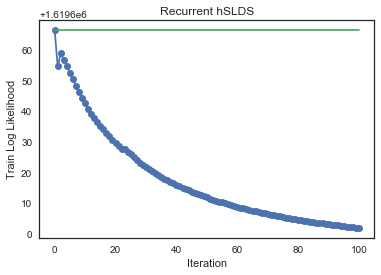

In [31]:
plt.plot(hrslds_lls, '-o')
# tmp = hslds.heldout_log_likelihood(data_masks_train)
# plt.plot(tmp * np.ones(len(hrslds_lls)))
tmp = hslds.heldout_log_likelihood(data_masks_train)
plt.plot(tmp * np.ones(len(hrslds_lls)))
plt.xlabel("Iteration")
plt.ylabel("Train Log Likelihood")
plt.title("Recurrent hSLDS")

# Plot recurrent hSLDS results

In [ ]:
# Note: name the files (r)ecuzrrent (h)ierarhical instead of hr... 
#       this will make it easier to navigate the results directory
for worm in range(N_worms):
    plot_discrete_state_samples(
        hrslds_z_smpls[worm], z_trues[worm], Kmax,
        filepath=os.path.join(results_dir, "rhslds_z_samples_worm{}.pdf".format(worm+1)))

In [ ]:
for worm in range(N_worms):
    plot_changepoint_prs(hrslds_z_smpls[worm], z_trues[worm],
                         title="Worm {} Discrete States".format(worm+1),
                         filepath=os.path.join(results_dir, "rhslds_cps_worm{}.pdf".format(worm+1)))

In [ ]:
for worm in range(N_worms):
    plot_3d_continuous_states(hrslds_x_finals[worm], hrslds_z_finals[worm], colors,
                              figsize=(4, 4),
                              title="Worm {} States".format(worm + 1),
                              lim=25,
                              results_dir=results_dir,
                              filename="rhslds_x_worm_{}.pdf".format(worm + 1),
                              lw=1)

In [ ]:
for worm in range(N_worms):
    make_states_3d_movie(hrslds_z_finals[worm], hrslds_x_finals[worm],
                         title="rhSLDS Smoothed States",
                         lim=25,
                         filepath=os.path.join(results_dir, "rhslds_x_worm{}.mp4".format(worm+1)))

In [ ]:
plot_3d_dynamics(
    hrslds_dynamics_distns, np.concatenate(hrslds_z_finals), np.vstack(hrslds_x_finals),
    colors=colors,
    lim=25,
    filepath=os.path.join(results_dir, "rhslds_dynamics.pdf"))


# Train a classifier to predict state from latent location

In [32]:
# Now try to estimate the transition probabilities
worm = 0
N_used = len(np.unique(hslds_z_finals[worm]))
from rslds.util import one_hot
from sklearn.linear_model.logistic import LogisticRegression
lr = LogisticRegression(verbose=False, multi_class="multinomial", solver="lbfgs")
# lr = LogisticRegression(verbose=False, multi_class="ovr")
lr_X = np.column_stack((one_hot(hslds.states_list[worm].stateseq[:-1], Kmax), 
                        hslds.states_list[worm].gaussian_states[:-1]))
lr_y = hslds.states_list[worm].stateseq[1:]
lr.fit(lr_X, lr_y)

# See how well the classifier performs|
lr_score = lr.score(lr_X, lr_y)
lr_probs = lr.predict_proba(lr_X)
print(lr_score)

0.936878216123


In [33]:
# hrslds2 = copy_hslds_to_hrslds(hslds)
W = hrslds.trans_distn.W
logpi = hrslds.trans_distn.logpi
lr2 = LogisticRegression(verbose=False, multi_class="multinomial", solver="lbfgs")
lr2.fit(np.random.randn(Kmax, Kmax + D_latent), np.arange(Kmax))
lr2.coef_ = np.vstack((logpi, W)).T
lr2.intercept_ = np.zeros(Kmax)

for worm in range(N_worms):
    lr_X = np.column_stack((one_hot(hrslds.states_list[worm].stateseq[:-1], Kmax), 
                            hrslds.states_list[worm].gaussian_states[:-1]))
    lr_y = hrslds.states_list[worm].stateseq[1:]

    print(lr2.score(lr_X, lr_y))


0.938250428816
0.935506003431
0.917324185249
0.955746140652
0.942710120069


# Simulate from the models

In [34]:
def simulate_forward(model, ic, T_gen, noise_downscale=1.0, group=None):
    orig_dynamics_distns = copy.deepcopy(model.dynamics_distns)
    for dd in model.dynamics_distns:
        dd.sigma *= noise_downscale    

    kwargs = dict(group=group) if group is not None else {}
    y_gen, x_gen, z_gen = \
        model.generate(T=T_gen, inputs=inputs, keep=False,
                       with_noise=True, initial_condition=ic,
                      **kwargs)
        
    model.dynamics_distns = orig_dynamics_distns
    
    return y_gen, x_gen, z_gen

In [35]:
T_pred = 3 * 2
inputs = np.ones((T_pred, 1))
worm_to_simulate = 1

# Pick a place to simulate from
z0 = 7
tmp = np.where(hrslds_z_finals[worm_to_simulate] == z0)[0]
assert len(tmp) > 0
x0 = hrslds_x_finals[worm_to_simulate][tmp[0]]
ic = (z0, x0)

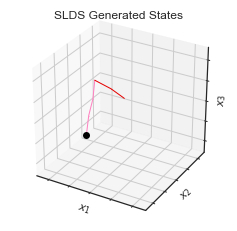

In [36]:
slds_y_gen, slds_x_gen, slds_z_gen = simulate_forward(slds, ic, T_pred)

plot_3d_continuous_states(slds_x_gen, slds_z_gen, colors,
                          figsize=(4, 4),
                          lim=25,
                          title="SLDS Generated States",
                          results_dir=results_dir,
                          filename=None,
                          lw=1)


plt.plot([x0[0]], [x0[1]], [x0[2]], 'ko')

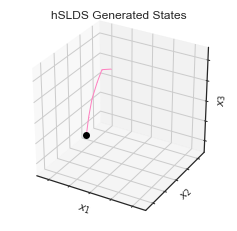

In [37]:
hslds_y_gen, hslds_x_gen, hslds_z_gen = simulate_forward(hslds, ic, T_pred, group=worm_to_simulate)

plot_3d_continuous_states(hslds_x_gen, hslds_z_gen, colors,
                          figsize=(4, 4),
                          lim=25,
                          title="hSLDS Generated States",
                          results_dir=results_dir,
                          filename=None,
                          lw=1)


plt.plot([x0[0]], [x0[1]], [x0[2]], 'ko')

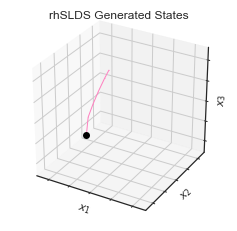

In [38]:
hrslds_y_gen, hrslds_x_gen, hrslds_z_gen = simulate_forward(hrslds, ic, T_pred, group=worm_to_simulate)

plot_3d_continuous_states(hrslds_x_gen, hrslds_z_gen, colors,
                          figsize=(4, 4),
                          lim=25,
                          title="rhSLDS Generated States",
                          results_dir=results_dir,
                          filename=None,
                          lw=1)


plt.plot([x0[0]], [x0[1]], [x0[2]], 'ko')

# Do online filtering of test data in order to evaluate the rolling predictions

In [39]:
def online_filtering(lds, slds, hslds, hrslds, y, mask, 
                     N_gibbs=200, N_vbem=50, group=0):
    T = y.shape[0]
    inputs = np.ones((T, D_in))

    # Initialize the outputs 
    lds_z_filt = np.zeros((T,), dtype=int)
    lds_x_filt = np.zeros((T, D_latent))
    slds_z_filt = np.zeros((T,), dtype=int)
    slds_x_filt = np.zeros((T, D_latent))
    hslds_z_filt = np.zeros((T,), dtype=int)
    hslds_x_filt = np.zeros((T, D_latent))
    hrslds_z_filt = np.zeros((T,), dtype=int)
    hrslds_x_filt = np.zeros((T, D_latent))

    lds_states = None

    def _copy_states(old_states, new_states):
        if old_states is not None:
            new_states.stateseq = old_states.stateseq.copy()
            new_states.gaussian_states = old_states.gaussian_states.copy()

            # todo: copy the expected stats as well
            new_states.expected_states = old_states.expected_states.copy()
            new_states.smoothed_mus = old_states.smoothed_mus.copy()
            new_states.smoothed_sigmas = old_states.smoothed_sigmas.copy()
            
            if old_states.E_emission_stats is None:
                old_states.vb_E_step_gaussian_states()
                
            new_states.E_init_stats = copy.deepcopy(old_states.E_init_stats)
            new_states.E_dynamics_stats = copy.deepcopy(old_states.E_dynamics_stats)
            new_states.E_emission_stats = copy.deepcopy(old_states.E_emission_stats)
        
            new_states.expected_joints = new_states.expected_states[:-1, :, None] * new_states.expected_states[1:, None, :]
            
            if hasattr(new_states, 'vbem_update_auxiliary_vars'):
                new_states._set_expected_trans_stats()
                new_states.vbem_update_auxiliary_vars(n_iter=10)
                       
        return new_states

    # Run the online filtering 
    for t in progprint_xrange(1,T):

        ### Fit the LDS with Gibbs
        lds.add_data(data=y[:t], mask=mask[:t], inputs=inputs[:t])
        s = lds.states_list.pop()
        if lds_states is not None:
            s.stateseq[:-1] = lds_states.stateseq.copy()
            s.gaussian_states[:-1] = lds_states.gaussian_states.copy()
            s.stateseq[-1] = s.stateseq[-2]
            s.gaussian_states[-1] = s.gaussian_states[-2]
        lds_states = s
        
        for itr in range(N_gibbs):
            lds_states.resample()
        lds_states._init_mf_from_gibbs()
        for itr in range(N_vbem):
            lds_states.vb_E_step()

        # Save out the current state 
        lds_z_filt[t] = lds_states.stateseq[-1]
        lds_x_filt[t] = lds_states.smoothed_mus[-1]
            
        ### Fit the SLDS with Gibbs
        slds.add_data(data=y[:t], mask=mask[:t], inputs=inputs[:t])
        slds_states = slds.states_list.pop()
        slds_states = _copy_states(lds_states, slds_states)
        
        for itr in range(N_gibbs):
            slds_states.resample()
        slds_states._init_mf_from_gibbs()
        for itr in range(N_vbem):
            slds_states.vb_E_step()
            
        # Save out the current state 
        slds_z_filt[t] = slds_states.stateseq[-1]
        slds_x_filt[t] = slds_states.smoothed_mus[-1]
        
        ### Fit the hSLDS with Gibbs
        hslds.add_data(data=y[:t], mask=mask[:t], inputs=inputs[:t], group=group)
        s = hslds.states_list.pop()
        hslds_states = _copy_states(slds_states, s)
        
        for itr in range(N_gibbs):
            hslds_states.resample()
        hslds_states._init_mf_from_gibbs()
        for itr in range(N_vbem):
            hslds_states.vb_E_step()
            
        # Save out the current state 
        hslds_z_filt[t] = hslds_states.stateseq[-1]
        hslds_x_filt[t] = hslds_states.smoothed_mus[-1]

        # Fit the rhSLDS with VBEM
        hrslds.add_data(data=y[:t], mask=mask[:t], inputs=inputs[:t], group=group)
        s = hrslds.states_list.pop()
        hrslds_states = _copy_states(hslds_states, s)
        for itr in range(N_vbem):
            hrslds_states.vb_E_step()
            
        # Save out the current state 
        hrslds_z_filt[t] = hrslds_states.stateseq[-1]
        hrslds_x_filt[t] = hrslds_states.smoothed_mus[-1]


    return lds_z_filt, lds_x_filt, \
           slds_z_filt, slds_x_filt, \
           hslds_z_filt, hslds_x_filt, \
           hrslds_z_filt, hrslds_x_filt

In [40]:
results = []
for group, (y, mask) in enumerate(zip(datasets_test, data_masks_test)):
    print("Online filtering worm ", group)
    _filt = cached("filtering_worm_{}".format(group))(online_filtering)
    results.append(
        _filt(lds, slds, hslds, hrslds, y, mask, 
                         N_gibbs=100, N_vbem=20, group=group))

lds_zs_filt, lds_xs_filt, slds_zs_filt, slds_xs_filt, \
hslds_zs_filt, hslds_xs_filt, hrslds_zs_filt, hrslds_xs_filt = tuple(zip(*results))

Online filtering worm  0
Online filtering worm  1
Online filtering worm  2
Online filtering worm  3
Online filtering worm  4


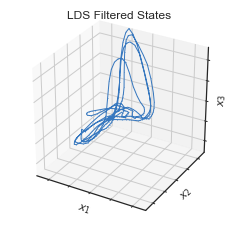

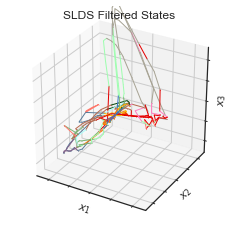

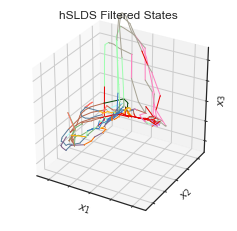

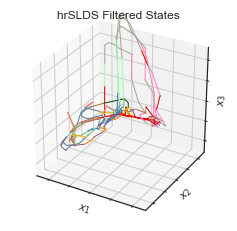

In [41]:
worm = 4
plot_3d_continuous_states(lds_xs_filt[worm], lds_zs_filt[worm], colors,
                          figsize=(4, 4),
                          title="LDS Filtered States",
                          results_dir=results_dir,
                          filename=None,
                          lim=25,
                          lw=1)

plot_3d_continuous_states(slds_xs_filt[worm], slds_zs_filt[worm], colors,
                          figsize=(4, 4),
                          title="SLDS Filtered States",
                          results_dir=results_dir,
                          filename=None,
                          lim=25,
                          lw=1)


plot_3d_continuous_states(hslds_xs_filt[worm], hslds_zs_filt[worm], colors,
                          figsize=(4, 4),
                          title="hSLDS Filtered States",
                          results_dir=results_dir,
                          filename=None,
                          lim=25,
                          lw=1)

plot_3d_continuous_states(hrslds_xs_filt[worm], hrslds_zs_filt[worm], colors,
                          figsize=(4, 4),
                          title="hrSLDS Filtered States",
                          results_dir=results_dir,
                          filename=None,
                          lim=25,
                          lw=1)

# Rolling prediction task

In [42]:
# Using the smoothed states, run each model forward making predictions 
# and see how well the predictions align with the smoothed states
def compare_predictions_to_smoothed(model, z_smooth, x_smooth, T_pred, N_sim=50, group=None):
    T = z_smooth.size
    assert x_smooth.shape == (T, D_latent)
    
    z_preds = np.empty((N_sim, T-T_pred, T_pred))
    x_preds = np.empty((N_sim, T-T_pred, T_pred, D_latent))
    for t in progprint_xrange(T-T_pred):
        for i in range(N_sim):
            ic = (z_smooth[t], x_smooth[t])
            _, x_gen, z_gen = simulate_forward(model, ic, T_pred, group=group)
            z_preds[i, t, :] = z_gen
            x_preds[i, t, :, :] = x_gen
    
    return z_preds, x_preds

In [43]:
lds_zs_pred, lds_xs_pred = [], []
slds_zs_pred, slds_xs_pred = [], []
hslds_zs_pred, hslds_xs_pred = [], []
hrslds_zs_pred, hrslds_xs_pred = [], []

for worm in range(N_worms):
    print("Simulating predictions worm ", worm)
    _pred = cached("lds_pred_worm_{}".format(worm))(compare_predictions_to_smoothed)
    zp, xp = _pred(lds, lds_zs_filt[worm], lds_xs_filt[worm], T_pred)
    lds_zs_pred.append(zp)
    lds_xs_pred.append(xp)

    _pred = cached("slds_pred_worm_{}".format(worm))(compare_predictions_to_smoothed)
    zp, xp = _pred(slds, slds_zs_filt[worm], slds_xs_filt[worm], T_pred)
    slds_zs_pred.append(zp)
    slds_xs_pred.append(xp)
    
    _pred = cached("hslds_pred_worm_{}".format(worm))(compare_predictions_to_smoothed)
    zp, xp = _pred(hslds, hslds_zs_filt[worm], hslds_xs_filt[worm], T_pred, group=worm)
    hslds_zs_pred.append(zp)
    hslds_xs_pred.append(xp)
    
    _pred = cached("rhslds_pred_worm_{}".format(worm))(compare_predictions_to_smoothed)
    zp, xp = _pred(hrslds, hrslds_zs_filt[worm], hrslds_xs_filt[worm], T_pred, group=worm)
    hrslds_zs_pred.append(zp)
    hrslds_xs_pred.append(xp)

Simulating predictions worm  0
Simulating predictions worm  1
Simulating predictions worm  2
Simulating predictions worm  3
Simulating predictions worm  4


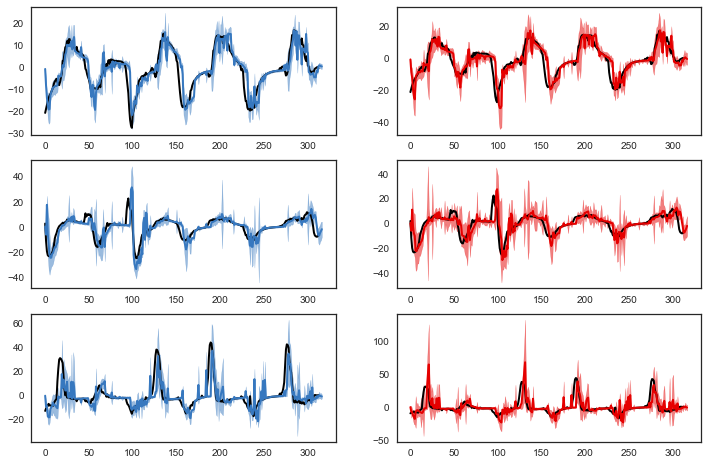

In [44]:
worm = 4
offset = T_pred-1
T_test = datasets_test[worm].shape[0]

plt.figure(figsize=(12,8))
for dim in range(D_latent):
    hrslds_x_pred_mean = np.mean(hrslds_xs_pred[worm][:,:,offset, dim], axis=0)
    hrslds_x_pred_std = np.std(hrslds_xs_pred[worm][:,:,offset, dim], axis=0)

    hslds_x_pred_mean = np.mean(hslds_xs_pred[worm][:,:,offset, dim], axis=0)
    hslds_x_pred_std = np.std(hslds_xs_pred[worm][:,:,offset, dim], axis=0)

    plt.subplot(3,2,dim*2+1)
    plt.plot(hrslds_xs_filt[worm][offset:T_test-offset, dim], '-k', lw=2)
    plt.plot(hrslds_x_pred_mean, color=colors[0], lw=2, label="hrslds")
    plt.fill_between(np.arange(T_test-T_pred), 
                     hrslds_x_pred_mean - 2 * hrslds_x_pred_std,
                     hrslds_x_pred_mean + 2 * hrslds_x_pred_std,
                     color=colors[0], alpha=0.5)
    
#     plt.plot([232], hrslds_x_finals[worm_to_simulate][offset+232, dim], 'yo')

    plt.subplot(3,2,dim*2+2)
    plt.plot(hslds_xs_filt[worm][offset:T_test-offset, dim], '-k', lw=2)
    plt.plot(hslds_x_pred_mean, color=colors[1], lw=2, label="hslds")
    plt.fill_between(np.arange(T_test-T_pred), 
                     hslds_x_pred_mean - 2 * hslds_x_pred_std,
                     hslds_x_pred_mean + 2 * hslds_x_pred_std,
                     color=colors[1], alpha=0.5)


In [45]:
def nrmse_rolling_prediction_obs(y_true, x_pred, emission_distn, mask):
    assert y_true.ndim == 2 and x_pred.ndim == 4
    T, N = y_true.shape
    N_pred, T_adj, T_pred, D = x_pred.shape
    assert T == T_adj + T_pred
    
    # Get the emission params
    C = emission_distn.A[:,:D_latent]
    d = emission_distn.A[:,D_latent]
    
    # Compute the Gaussian mean and covariance of the predictions
    nmse = np.zeros(T_adj)
    for t in range(T_adj):
        y_pred = np.tensordot(x_pred[:,t,:,:], C.T, axes=1) + d
        y_sqerr = np.mean((y_true[t:t+T_pred] - y_pred[:,:,:])**2, axis=0)
        nmse[t] = -np.sqrt(np.mean(y_sqerr[mask[t:t+T_pred]]))
    return nmse

Negative RMSE vs time (less negative is better) Worm  0
LDS:    -3.012
SLDS:   -2.520
hSLDS:  -2.501
rhSLDS: -2.437
Negative RMSE vs time (less negative is better) Worm  1
LDS:    -1.769
SLDS:   -0.843
hSLDS:  -0.801
rhSLDS: -0.771
Negative RMSE vs time (less negative is better) Worm  2
LDS:    -5.013
SLDS:   -4.695
hSLDS:  -4.677
rhSLDS: -4.639
Negative RMSE vs time (less negative is better) Worm  3
LDS:    -3.032
SLDS:   -2.720
hSLDS:  -2.652
rhSLDS: -2.634
Negative RMSE vs time (less negative is better) Worm  4
LDS:    -6.720
SLDS:   -6.540
hSLDS:  -6.665
rhSLDS: -6.478


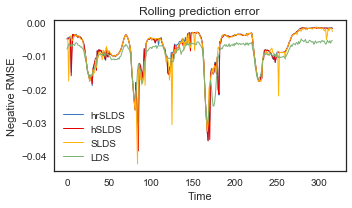

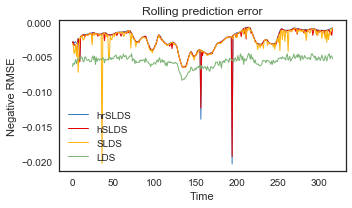

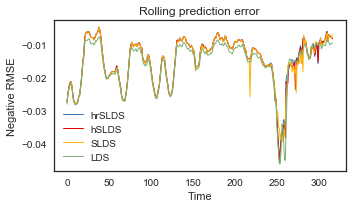

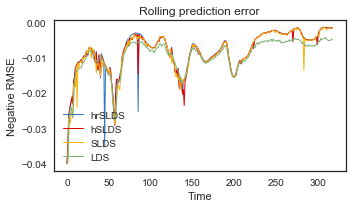

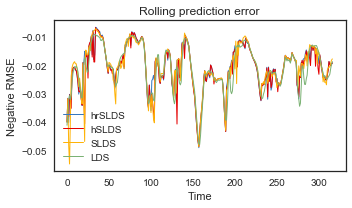

In [46]:
for worm in range(N_worms):
    lds_pred_nrmse = nrmse_rolling_prediction_obs(
        datasets_test[worm], lds_xs_pred[worm], lds._emission_distn, data_masks_test[worm])

    slds_pred_nrmse = nrmse_rolling_prediction_obs(
        datasets_test[worm], slds_xs_pred[worm], slds._emission_distn, data_masks_test[worm])

    hslds_pred_nrmse = nrmse_rolling_prediction_obs(
        datasets_test[worm], hslds_xs_pred[worm], hslds._emission_distn, data_masks_test[worm])

    hrslds_pred_nrmse = nrmse_rolling_prediction_obs(
        datasets_test[worm], hrslds_xs_pred[worm], hrslds._emission_distn, data_masks_test[worm])
    
    plt.figure(figsize=(5,3))
    plt.plot(hrslds_pred_nrmse, color=colors[0], lw=1, label="hrSLDS")
    plt.plot(hslds_pred_nrmse, color=colors[1], lw=1, label="hSLDS")
    plt.plot(slds_pred_nrmse, color=colors[2], lw=1, label="SLDS")
    plt.plot(lds_pred_nrmse, color=colors[3], lw=1, label="LDS")
    plt.legend(loc="lower left")
    plt.xlabel("Time")
    plt.ylabel("Negative RMSE")
    plt.title("Rolling prediction error")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "rolling_pred_error_worm_{}.pdf".format(worm)))


    print("Negative RMSE vs time (less negative is better) Worm ", worm)
    print("LDS:    {:.3f}".format(lds_pred_nrmse.sum()))
    print("SLDS:   {:.3f}".format(slds_pred_nrmse.sum()))
    print("hSLDS:  {:.3f}".format(hslds_pred_nrmse.sum()))
    print("rhSLDS: {:.3f}".format(hrslds_pred_nrmse.sum()))


In [77]:
# Print in a nice table form
for worm in range(N_worms):
    lds_pred_nrmse = nrmse_rolling_prediction_obs(
        datasets_test[worm], lds_xs_pred[worm], lds._emission_distn, data_masks_test[worm])

    slds_pred_nrmse = nrmse_rolling_prediction_obs(
        datasets_test[worm], slds_xs_pred[worm], slds._emission_distn, data_masks_test[worm])

    hslds_pred_nrmse = nrmse_rolling_prediction_obs(
        datasets_test[worm], hslds_xs_pred[worm], hslds._emission_distn, data_masks_test[worm])

    hrslds_pred_nrmse = nrmse_rolling_prediction_obs(
        datasets_test[worm], hrslds_xs_pred[worm], hrslds._emission_distn, data_masks_test[worm])
    
    print("Worm ", worm+1)
    print("{:.5f} +- {:.5f}".format(lds_pred_nrmse.mean(), lds_pred_nrmse.std()))
    print("{:.5f} +- {:.5f}".format(slds_pred_nrmse.mean(), slds_pred_nrmse.std()))
    print("{:.5f} +- {:.5f}".format(hslds_pred_nrmse.mean(), hslds_pred_nrmse.std()))
    print("{:.5f} +- {:.5f}".format(hrslds_pred_nrmse.mean(), hrslds_pred_nrmse.std()))


Worm  1
-0.00950 +- 0.00452
-0.00795 +- 0.00604
-0.00789 +- 0.00615
-0.00769 +- 0.00592
Worm  2
-0.00558 +- 0.00069
-0.00266 +- 0.00164
-0.00253 +- 0.00167
-0.00243 +- 0.00176
Worm  3
-0.01581 +- 0.00722
-0.01481 +- 0.00703
-0.01475 +- 0.00725
-0.01463 +- 0.00720
Worm  4
-0.00954 +- 0.00524
-0.00855 +- 0.00605
-0.00834 +- 0.00570
-0.00828 +- 0.00595
Worm  5
-0.02120 +- 0.00770
-0.02063 +- 0.00815
-0.02102 +- 0.00775
-0.02044 +- 0.00749


In [70]:
# Make a movie of the rolling predictions
def make_state_predictions_3d_movie(
    z_smooth, x_smooth,
    z_pred, x_pred, 
    title=None, 
    lim=None,
    colors=None,
    figsize=(4,4),
    filepath=None):

    # colors = default_colors if colors is None else colors
    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title='3d states field')
    writer = FFMpegWriter(fps=15, bitrate=1024, metadata=metadata)

    # overlay = False
    fig = plt.figure(figsize=figsize)
    ax = create_axis_at_location(fig, 0, 0, figsize[0], figsize[1], projection="3d")

    # Initialize the plots
    N_pred, T, T_pred, _ = x_pred.shape
    h_time = ax.text(15, -15, -20, "T=0")
    h_prev = plt.plot(x_smooth[:1,0], x_smooth[:1,1], x_smooth[:1,2], lw=1, color='gray')
    h_curs = plt.plot([x_smooth[0,0]], [x_smooth[0,1]], [x_smooth[0,2]], 'ko')[0]
    h_true = plt.plot(x_smooth[:T_pred, 0], 
                      x_smooth[:T_pred, 1], 
                      x_smooth[:T_pred, 2], 
                      '-k', lw=2)[0]

    h_preds = []
    for n in range(N_pred):
        h_preds.append(
            plt.plot(x_pred[n, 0, :, 0],
                     x_pred[n, 0, :, 1],
                     x_pred[n, 0, :, 2],
                     color=colors[0], lw=0.5)[0])
    
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_zlabel("")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    if lim is not None:
        ax.set_xlim(-lim,lim)
        ax.set_ylim(-lim,lim)
        ax.set_zlim(-lim,lim)

    ax.set_title(title)

    def update_frame(t):
        # Rotate the xy plane
        # ax.view_init(elev=30., azim=i)

        # Update the trajectories
        h_time.set_text("T={}".format(t))
        h_prev[0].remove()
        t_prev = max(t-T_pred, 0)
        h_prev[0] = plt.plot(x_smooth[t_prev:t+1,0], 
                             x_smooth[t_prev:t+1,1], 
                             x_smooth[t_prev:t+1,2], 
                             lw=1, color='gray')[0]
        h_curs.set_data(([x_smooth[t,0]], [x_smooth[t,1]]))
        h_curs.set_3d_properties([x_smooth[t,2]])
        
        h_true.set_data((x_smooth[t:t+T_pred, 0], 
                         x_smooth[t:t+T_pred, 1]))
        h_true.set_3d_properties(x_smooth[t:t+T_pred, 2])
        
        for n,h in enumerate(h_preds):
            h.set_data((x_pred[n,t,:,0],
                        x_pred[n,t,:,1]))
            h.set_3d_properties(x_pred[n,t,:,2])
                    
    with writer.saving(fig, filepath, 150):
        for i in progprint_xrange(T):
            update_frame(i)
            writer.grab_frame()

In [ ]:
for worm in range(N_worms):
    make_state_predictions_3d_movie(
        None, lds_xs_filt[worm], None, lds_xs_pred[worm], 
        colors=colors, lim=25, title="LDS Worm {}".format(worm+1), 
        filepath=os.path.join(results_dir, "lds_predicted_states_worm_{}.mp4".format(worm)))
    
    make_state_predictions_3d_movie(
        slds_zs_filt[worm], slds_xs_filt[worm], slds_zs_pred[worm], slds_xs_pred[worm], 
        colors=colors, lim=25, title="SLDS Worm {}".format(worm+1), 
        filepath=os.path.join(results_dir, "slds_predicted_states_worm_{}.mp4".format(worm)))
    
    make_state_predictions_3d_movie(
        hslds_zs_filt[worm], hslds_xs_filt[worm], hslds_zs_pred[worm], hslds_xs_pred[worm], 
        colors=colors, lim=25, title="hSLDS Worm {}".format(worm+1), 
        filepath=os.path.join(results_dir, "hslds_predicted_states_worm_{}.mp4".format(worm)))
    
    make_state_predictions_3d_movie(
        hrslds_zs_filt[worm], hrslds_xs_filt[worm], hrslds_zs_pred[worm], hrslds_xs_pred[worm], 
        colors=colors, lim=25, title="hrSLDS Worm {}".format(worm+1), 
        filepath=os.path.join(results_dir, "rhslds_predicted_states_worm_{}.mp4".format(worm)))

# Do something similar but with smoothed data
This basically tests how well the (r)SLDS can predict its own future states.

In [65]:
def smooth_test_data(lds, slds, hslds, hrslds, y, mask, 
                     N_gibbs=200, N_vbem=50, group=0):
    T = y.shape[0]
    inputs = np.ones((T, D_in))

    lds_states = None

    def _copy_states(old_states, new_states):
        if old_states is not None:
            new_states.stateseq = old_states.stateseq.copy()
            new_states.gaussian_states = old_states.gaussian_states.copy()

            # todo: copy the expected stats as well
            new_states.expected_states = old_states.expected_states.copy()
            new_states.smoothed_mus = old_states.smoothed_mus.copy()
            new_states.smoothed_sigmas = old_states.smoothed_sigmas.copy()
            
            if old_states.E_emission_stats is None:
                old_states.vb_E_step_gaussian_states()
                
            new_states.E_init_stats = copy.deepcopy(old_states.E_init_stats)
            new_states.E_dynamics_stats = copy.deepcopy(old_states.E_dynamics_stats)
            new_states.E_emission_stats = copy.deepcopy(old_states.E_emission_stats)
        
            new_states.expected_joints = new_states.expected_states[:-1, :, None] * new_states.expected_states[1:, None, :]
            
            if hasattr(new_states, 'vbem_update_auxiliary_vars'):
                new_states._set_expected_trans_stats()
                new_states.vbem_update_auxiliary_vars(n_iter=10)
                       
        return new_states


    ### Fit the LDS with Gibbs
    lds.add_data(data=y, mask=mask, inputs=inputs)
    lds_states = lds.states_list.pop()

    for itr in progprint_xrange(N_gibbs):
        lds_states.resample()
    lds_states._init_mf_from_gibbs()
    for itr in progprint_xrange(N_vbem):
        lds_states.vb_E_step()

    # Save out the current state 
    lds_z_smooth = lds_states.stateseq
    lds_x_smooth = lds_states.smoothed_mus

    ### Fit the SLDS with Gibbs
    slds.add_data(data=y, mask=mask, inputs=inputs)
    slds_states = slds.states_list.pop()
    slds_states = _copy_states(lds_states, slds_states)

    for itr in progprint_xrange(N_gibbs):
        slds_states.resample()
    slds_states._init_mf_from_gibbs()
    for itr in progprint_xrange(N_vbem):
        slds_states.vb_E_step()

    # Save out the current state 
    slds_z_smooth = slds_states.stateseq
    slds_x_smooth = slds_states.smoothed_mus

    ### Fit the hSLDS with Gibbs
    hslds.add_data(data=y, mask=mask, inputs=inputs, group=group)
    s = hslds.states_list.pop()
    hslds_states = _copy_states(slds_states, s)

    for itr in progprint_xrange(N_gibbs):
        hslds_states.resample()
    hslds_states._init_mf_from_gibbs()
    for itr in progprint_xrange(N_vbem):
        hslds_states.vb_E_step()

    # Save out the current state 
    hslds_z_smooth = hslds_states.stateseq
    hslds_x_smooth = hslds_states.smoothed_mus

    # Fit the rhSLDS with VBEM
    hrslds.add_data(data=y, mask=mask, inputs=inputs, group=group)
    s = hrslds.states_list.pop()
    hrslds_states = _copy_states(hslds_states, s)
    for itr in progprint_xrange(N_vbem):
        hrslds_states.vb_E_step()

    # Save out the current state 
    hrslds_z_smooth = hrslds_states.stateseq
    hrslds_x_smooth = hrslds_states.smoothed_mus


    return lds_z_smooth, lds_x_smooth, \
           slds_z_smooth, slds_x_smooth, \
           hslds_z_smooth, hslds_x_smooth, \
           hrslds_z_smooth, hrslds_x_smooth

In [66]:
results = []
for group, (y, mask) in enumerate(zip(datasets_test, data_masks_test)):
    print("Smoothing worm ", group)
    _smooth = cached("test_smoothing_worm_{}".format(group))(smooth_test_data)
    results.append(
        _smooth(lds, slds, hslds, hrslds, y, mask, 
                N_gibbs=100, N_vbem=20, group=group))

lds_zs_smooth, lds_xs_smooth, slds_zs_smooth, slds_xs_smooth, \
hslds_zs_smooth, hslds_xs_smooth, hrslds_zs_smooth, hrslds_xs_smooth = tuple(zip(*results))

Smoothing worm  0
.........................  [  25/100,    0.01sec avg, ETA 0.49 ]
.........................  [  50/100,    0.01sec avg, ETA 0.32 ]
.........................  [  75/100,    0.01sec avg, ETA 0.16 ]
.........................  [ 100/100,    0.01sec avg, ETA 0.00 ]

   0.01sec avg, 0.62 total

....................
   0.01sec avg, 0.25 total

.........................  [  25/100,    0.02sec avg, ETA 1.84 ]
.........................  [  50/100,    0.02sec avg, ETA 1.18 ]
.........................  [  75/100,    0.02sec avg, ETA 0.59 ]
.........................  [ 100/100,    0.02sec avg, ETA 0.00 ]

   0.02sec avg, 2.37 total

....................
   0.03sec avg, 0.55 total

.........................  [  25/100,    0.02sec avg, ETA 1.73 ]
.........................  [  50/100,    0.02sec avg, ETA 1.14 ]
.........................  [  75/100,    0.02sec avg, ETA 0.62 ]
.........................  [ 100/100,    0.02sec avg, ETA 0.00 ]

   0.02sec avg, 2.48 total

.................

In [67]:
def nrmse_rolling_prediction_x(x_smooth, x_pred):
    assert x_smooth.ndim == 2 and x_pred.ndim == 4
    T, D = x_smooth.shape
    N_pred, T_adj, T_pred, D = x_pred.shape
    assert T == T_adj + T_pred
        
    # Compute the Gaussian mean and covariance of the predictions
    nmse = np.zeros(T_adj)
    for t in range(T_adj):
        x_sqerr = np.mean((x_smooth[t:t+T_pred] - x_pred[:,t,:,:])**2, axis=0)
        nmse[t] = -np.sqrt(np.mean(x_sqerr))
    return nmse

Negative RMSE vs time (less negative is better) Worm  0
LDS:    -871.157
SLDS:   -615.027
hSLDS:  -600.150
rhSLDS: -554.714
Negative RMSE vs time (less negative is better) Worm  1
LDS:    -697.043
SLDS:   -154.813
hSLDS:  -117.446
rhSLDS: -82.115
Negative RMSE vs time (less negative is better) Worm  2
LDS:    -874.415
SLDS:   -488.629
hSLDS:  -445.516
rhSLDS: -395.056
Negative RMSE vs time (less negative is better) Worm  3
LDS:    -888.018
SLDS:   -684.042
hSLDS:  -679.503
rhSLDS: -615.941
Negative RMSE vs time (less negative is better) Worm  4
LDS:    -1601.007
SLDS:   -1671.051
hSLDS:  -1678.899
rhSLDS: -1510.421


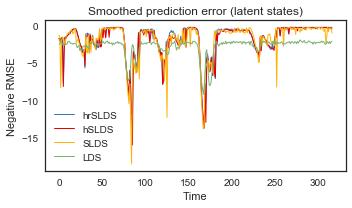

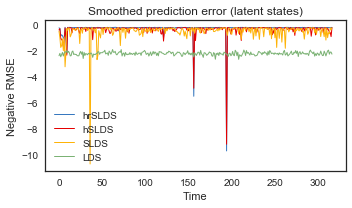

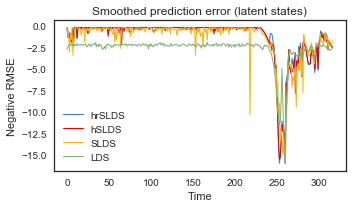

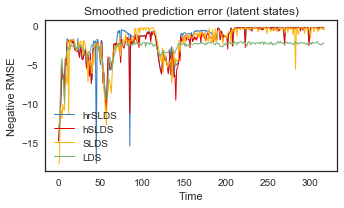

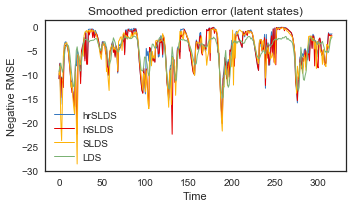

In [69]:
for worm in range(N_worms):
    lds_smooth_nrmse = nrmse_rolling_prediction_x(
        lds_xs_smooth[worm], lds_xs_pred[worm])

    slds_smooth_nrmse = nrmse_rolling_prediction_x(
        slds_xs_smooth[worm], slds_xs_pred[worm])

    hslds_smooth_nrmse = nrmse_rolling_prediction_x(
        hslds_xs_smooth[worm], hslds_xs_pred[worm])

    hrslds_smooth_nrmse = nrmse_rolling_prediction_x(
        hrslds_xs_smooth[worm], hrslds_xs_pred[worm])
    
    plt.figure(figsize=(5,3))
    plt.plot(hrslds_smooth_nrmse, color=colors[0], lw=1, label="hrSLDS")
    plt.plot(hslds_smooth_nrmse, color=colors[1], lw=1, label="hSLDS")
    plt.plot(slds_smooth_nrmse, color=colors[2], lw=1, label="SLDS")
    plt.plot(lds_smooth_nrmse, color=colors[3], lw=1, label="LDS")
    plt.legend(loc="lower left")
    plt.xlabel("Time")
    plt.ylabel("Negative RMSE")
    plt.title("Smoothed prediction error (latent states)")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "smoothed_pred_error_x_worm_{}.pdf".format(worm)))


    print("Negative RMSE vs time (less negative is better) Worm ", worm)
    print("LDS:    {:.3f}".format(lds_smooth_nrmse.sum()))
    print("SLDS:   {:.3f}".format(slds_smooth_nrmse.sum()))
    print("hSLDS:  {:.3f}".format(hslds_smooth_nrmse.sum()))
    print("rhSLDS: {:.3f}".format(hrslds_smooth_nrmse.sum()))


.........................  [  25/317,    0.05sec avg, ETA 15.70 ]
.........................  [  50/317,    0.05sec avg, ETA 14.06 ]
.........................  [  75/317,    0.05sec avg, ETA 12.72 ]
.........................  [ 100/317,    0.05sec avg, ETA 11.38 ]
.........................  [ 125/317,    0.05sec avg, ETA 10.06 ]
.........................  [ 150/317,    0.05sec avg, ETA 8.76 ]
.........................  [ 175/317,    0.05sec avg, ETA 7.47 ]
.........................  [ 200/317,    0.05sec avg, ETA 6.31 ]
.........................  [ 225/317,    0.05sec avg, ETA 4.94 ]
.........................  [ 250/317,    0.05sec avg, ETA 3.56 ]
.........................  [ 275/317,    0.05sec avg, ETA 2.21 ]
.........................  [ 300/317,    0.05sec avg, ETA 0.90 ]
.................
   0.05sec avg, 16.78 total

.........................  [  25/317,    0.05sec avg, ETA 13.71 ]
.........................  [  50/317,    0.05sec avg, ETA 13.66 ]
.........................  [  75/317

.........................  [ 300/317,    0.07sec avg, ETA 1.13 ]
.................
   0.07sec avg, 20.92 total

.........................  [  25/317,    0.06sec avg, ETA 17.73 ]
.........................  [  50/317,    0.06sec avg, ETA 16.13 ]
.........................  [  75/317,    0.06sec avg, ETA 14.31 ]
.........................  [ 100/317,    0.06sec avg, ETA 12.78 ]
.........................  [ 125/317,    0.06sec avg, ETA 12.03 ]
.........................  [ 150/317,    0.06sec avg, ETA 10.70 ]
.........................  [ 175/317,    0.06sec avg, ETA 9.14 ]
.........................  [ 200/317,    0.07sec avg, ETA 7.78 ]
.........................  [ 225/317,    0.07sec avg, ETA 6.11 ]
.........................  [ 250/317,    0.07sec avg, ETA 4.44 ]
.........................  [ 275/317,    0.07sec avg, ETA 2.78 ]
.........................  [ 300/317,    0.07sec avg, ETA 1.12 ]
.................
   0.07sec avg, 20.96 total

.........................  [  25/317,    0.07sec avg, E

.........................  [ 250/317,    0.06sec avg, ETA 3.75 ]
.........................  [ 275/317,    0.06sec avg, ETA 2.36 ]
.........................  [ 300/317,    0.06sec avg, ETA 0.96 ]
.................
   0.06sec avg, 18.03 total



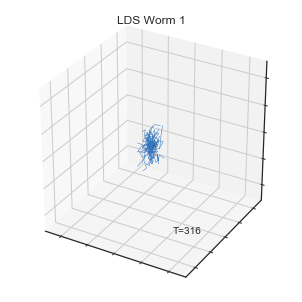

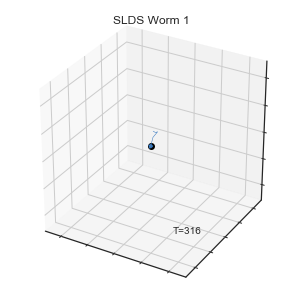

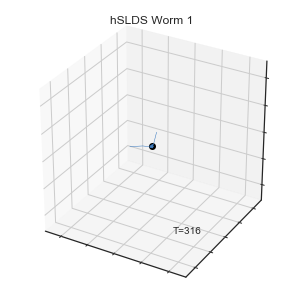

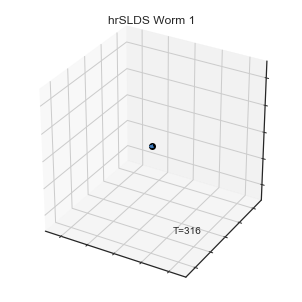

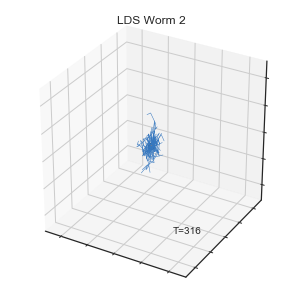

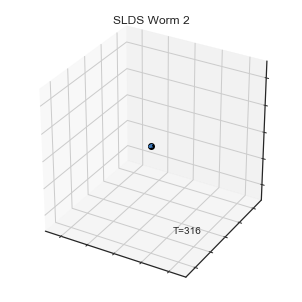

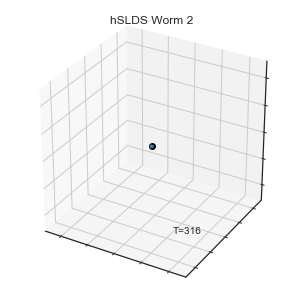

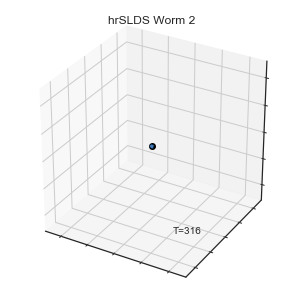

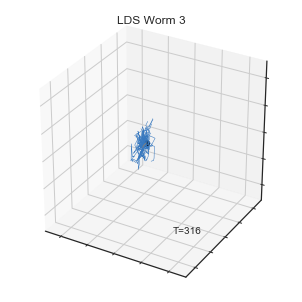

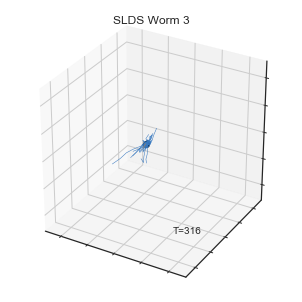

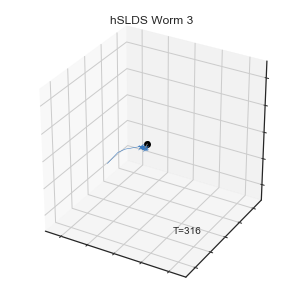

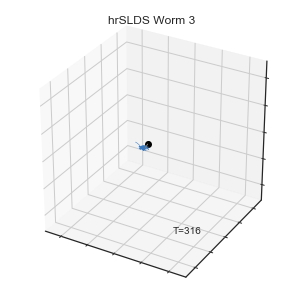

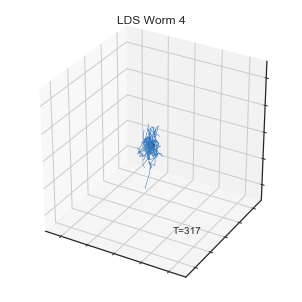

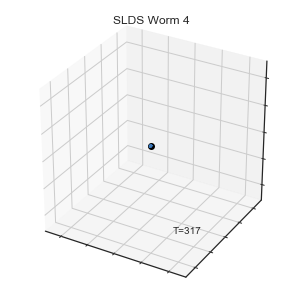

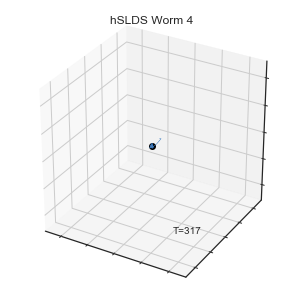

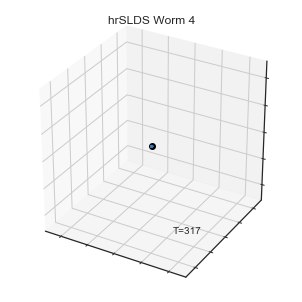

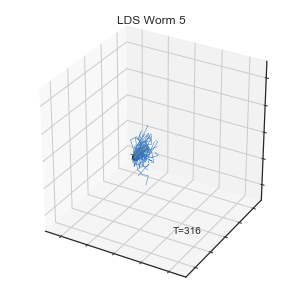

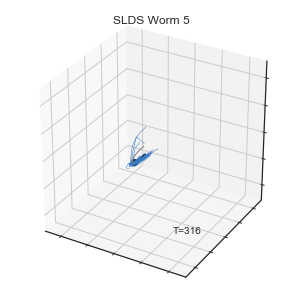

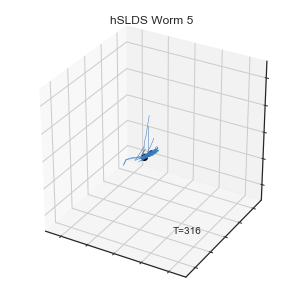

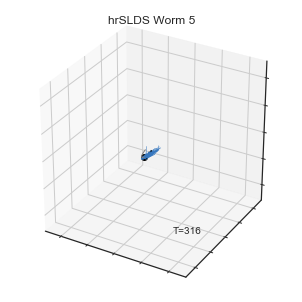

In [71]:
for worm in range(N_worms):
    make_state_predictions_3d_movie(
        None, lds_xs_smooth[worm], None, lds_xs_pred[worm], 
        colors=colors, lim=25, title="LDS Worm {}".format(worm+1), 
        filepath=os.path.join(results_dir, "lds_predicted_smooth_states_worm_{}.mp4".format(worm)))
    
    make_state_predictions_3d_movie(
        slds_zs_smooth[worm], slds_xs_smooth[worm], slds_zs_pred[worm], slds_xs_pred[worm], 
        colors=colors, lim=25, title="SLDS Worm {}".format(worm+1), 
        filepath=os.path.join(results_dir, "slds_predicted_smooth_states_worm_{}.mp4".format(worm)))
    
    make_state_predictions_3d_movie(
        hslds_zs_smooth[worm], hslds_xs_smooth[worm], hslds_zs_pred[worm], hslds_xs_pred[worm], 
        colors=colors, lim=25, title="hSLDS Worm {}".format(worm+1), 
        filepath=os.path.join(results_dir, "hslds_predicted_smooth_states_worm_{}.mp4".format(worm)))
    
    make_state_predictions_3d_movie(
        hrslds_zs_smooth[worm], hrslds_xs_smooth[worm], hrslds_zs_pred[worm], hrslds_xs_pred[worm], 
        colors=colors, lim=25, title="hrSLDS Worm {}".format(worm+1), 
        filepath=os.path.join(results_dir, "rhslds_predicted_smooth_states_worm_{}.mp4".format(worm)))